In [64]:
import pandas as pd
import plotly.express as px
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib
from multiprocessing import freeze_support
import reverse_geocoder as rg
from pyproj import Geod
import pickle
from tqdm import tqdm
import json
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches
from ndt_probe_results import ndt_probe_res_gen1, ndt_probe_res_gen2
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
from geopy import distance
import geopy
import pycountry
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import json
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import json
pd.set_option('display.max_rows', 100)  # Replace 100 with your desired value

# Enable tqdm for Pandas
tqdm.pandas()

### Helper functions for geography-based analysis

In [54]:
# mapping of country name to two-letter country code 
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2
# Defining some countries to match the format of pycountry package
countries["United States of America"] = "US"
countries["Dominican Rep."] = "DO"
countries["Palestine"] = "PS"
countries["S. Sudan"] = "SS"
countries["Solomon Is."] = "SB"
countries["eSwatini"] = "SZ"
countries["N. Cyprus"] = "NCY"
eu_countries = [
    'France',
    'N. Cyprus',
    "Greece",
    "Portugal",
    "Spain",
    "Bulgaria",
    "Romania",
    "Slovenia",
    "Hungary",
    "Slovakia",
    "Austria",
    "Luxembourg",
    "Czechia",
    "Poland",
    "Netherlands",
    "Ireland",
    "Lithuania",
    "Denmark",
    "Latvia",
    "Sweden",
    "Finland",
    ]

eastern_europe = [
    "BG",  # Bulgaria
    "CZ",  # Czech Republic
    "EE",  # Estonia
    "HU",  # Hungary
    "LT",  # Lithuania
    "LV",  # Latvia
    "PL",  # Poland
    "RO",  # Romania
    "SK",  # Slovakia
    "SI",  # Slovenia
    "HR",  # Croatia
    "RS",  # Serbia
    "BA",  # Bosnia and Herzegovina
    "ME",  # Montenegro
    "MK",  # North Macedonia
    "AL",  # Albania
    "BY",  # Belarus
    "MD",  # Moldova
    "UA",  # Ukraine
]

western_europe = [
    "AT",  # Austria
    "BE",  # Belgium
    "CH",  # Switzerland
    "DE",  # Germany
    "FR",  # France
    "IE",  # Ireland
    "LI",  # Liechtenstein
    "LU",  # Luxembourg
    "MC",  # Monaco
    "NL",  # Netherlands
]

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Function to check which country a point belongs to
def find_country_by_coords(lat, lon):
    point = Point(lon, lat)
    
    # Check if the point lies within any country's boundary
    for idx, row in world.iterrows():
        if row['geometry'].contains(point):
            return row['name']  # Return the name of the country
    
    return "No country found"

def calc_distance_from_nearest_gs(df,lat,lon):
    closest_dist = float('inf')
    gs_location = None
    for idx, row in df.iterrows():
        dist = distance.geodesic((lat, lon), (row["Latitude"],row["Longitude"])).km
        if dist < closest_dist:
            closest_dist = dist
            gs_location = row[1]
    return closest_dist, gs_location


def calc_closest_pop(pops,lat,lon):
    closest_dist = float('inf')
    pop_location = None
    for key, coords in pops.values():
        dist = distance.geodesic((lat, lon), coords).km
        if dist < closest_dist:
            closest_dist = dist
            pop_location = key
    return closest_dist, pop_location


/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/3974772047.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Loading in data from BigQuery results.. originally separated to not exceed quota... These queries can be consolidated..

all_downloads_starlink
```
SELECT 
  date, 
  a.CongestionControl, 
  a.LossRate, 
  a.MeanThroughputMbps, 
  a.MinRTT,
  client.Geo.Latitude as client_latitude, 
  client.Geo.Longitude as client_longitude, 
  client.Network.ASNumber as client_AS,
  client.Geo.CountryCode as client_country_code,
  server.Geo.Latitude as server_latitude,
  server.Geo.Longitude as server_longitude
FROM `measurement-lab.ndt.unified_downloads`
WHERE client.Network.ASNumber = 14593
AND date BETWEEN DATE("2024-01-01") AND DATE("2024-12-31")
```
non_starlink_data (this shows up later)
```
SELECT 
  date, 
  a.CongestionControl, 
  a.LossRate, 
  a.MeanThroughputMbps, 
  a.MinRTT,
  client.Geo.Latitude as client_latitude, 
  client.Geo.Longitude as client_longitude, 
  client.Network.ASNumber as client_AS,
  client.Geo.CountryCode as client_country_code,
  server.Geo.Latitude as server_latitude,
  server.Geo.Longitude as server_longitude
FROM `measurement-lab.ndt.unified_downloads`
WHERE client.Network.ASNumber != 14593
AND date BETWEEN DATE("2024-01-01") AND DATE("2024-12-31")
```
the combined_data.csv file is not pertinent to the analysis for TPRC results

In [8]:
all_downloads_starlink = pd.read_csv("/Users/isuizo/LEO_res_simulator/mlab_unified_downloads.csv")
all_downloads_starlink = all_downloads_starlink[all_downloads_starlink['client_latitude'].notna()]
all_downloads_starlink = all_downloads_starlink[all_downloads_starlink['client_longitude'].notna()]
all_downloads_starlink["starlink"] = True
all_downloads_non_starlink = pd.read_csv("/Users/isuizo/LEO_res_simulator/combined_data.csv")
all_downloads_non_starlink = all_downloads_non_starlink[all_downloads_non_starlink['client_latitude'].notna()]
all_downloads_non_starlink = all_downloads_non_starlink[all_downloads_non_starlink['client_longitude'].notna()]
all_downloads_non_starlink["starlink"] = False
all_downloads = pd.concat([all_downloads_starlink, all_downloads_non_starlink])
all_downloads['date'] = pd.to_datetime(all_downloads['date'])


Applying 2 filters
- only taking 6 month period between 5/2024 and 10/2024
- only taking samples that use bbr

In [12]:
filtered_df = all_downloads[(all_downloads['date'].dt.month <= 10) & (all_downloads['date'].dt.month >= 5)]
filtered_df = filtered_df[filtered_df["CongestionControl"] == "bbr"]

KeyboardInterrupt: 

In [10]:
# calculating client to NDT server distance
filtered_df["client_server_distance"] = filtered_df.progress_apply(lambda x: distance.geodesic((x["client_latitude"], x["client_longitude"]), (x["server_latitude"],x["server_longitude"])).km, axis=1)

100%|██████████| 16322402/16322402 [16:37<00:00, 16361.86it/s]


In [14]:
gni_per_capita = pd.read_csv("gni_per_capita.csv")
gni_per_capita_df = gni_per_capita[['Country Name', 'Country Code', '2021']]
country_name_to_gni_per_capita = gni_per_capita_df.set_index('Country Name')['2021'].to_dict()
country_code_to_gni_per_capita = gni_per_capita_df.set_index('Country Code')['2021'].to_dict()

# Uncomment if want to filter only by locations with samples >10 
#avg_tput = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"]).filter(lambda x : len(x) >= 10).groupby(["client_latitude", "client_longitude"])["MeanThroughputMbps"].mean().reset_index()
#avg_loss = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"]).filter(lambda x : len(x) >= 10).groupby(["client_latitude", "client_longitude"])["LossRate"].mean().reset_index()

avg_tput = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"])["MeanThroughputMbps"].mean().reset_index()
avg_loss = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"])["LossRate"].mean().reset_index()

starlink_avg_per_loc = avg_tput.merge(avg_loss, on=["client_latitude","client_longitude"])
starlink_avg_per_loc['client_country'] = starlink_avg_per_loc.progress_apply(lambda x: find_country_by_coords(x['client_latitude'], x['client_longitude']),axis=1)

starlink_avg_per_loc = starlink_avg_per_loc[starlink_avg_per_loc['client_country'] != "No country found"]
starlink_avg_per_loc['client_country_code'] = starlink_avg_per_loc['client_country'].map(countries)
starlink_avg_per_loc["gni"] = starlink_avg_per_loc['client_country_code'].map(country_code_to_gni_per_capita)

max_tput = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"])["MeanThroughputMbps"].max().reset_index()
max_loss = filtered_df[filtered_df["starlink"]].groupby(["client_latitude", "client_longitude"])["LossRate"].max().reset_index()

starlink_max_per_loc = max_tput.merge(max_loss, on=["client_latitude","client_longitude"])
starlink_max_per_loc['client_country'] = starlink_max_per_loc.progress_apply(lambda x: find_country_by_coords(x['client_latitude'], x['client_longitude']),axis=1)

starlink_max_per_loc = starlink_max_per_loc[starlink_max_per_loc['client_country'] != "No country found"]
starlink_max_per_loc['client_country_code'] = starlink_max_per_loc['client_country'].map(countries)
starlink_max_per_loc["gni"] = starlink_max_per_loc['client_country_code'].map(country_code_to_gni_per_capita)

100%|██████████| 298/298 [00:00<00:00, 754.17it/s]


In [15]:
# Cutting into bins 
# 0-25Mbps:unserved, 25-100Mbps:underserved, 100Mbps+: served

bins = [0, 25, 100, float("inf")]
bin_labels = ["unserved", "underserved", "served"]
starlink_avg_per_loc["category"] = pd.cut(starlink_avg_per_loc["MeanThroughputMbps"], right=False, bins=bins, labels=bin_labels)
bins = [0, 25, 100, float("inf")]
bin_labels = ["unserved", "underserved", "served"]
starlink_max_per_loc["category"] = pd.cut(starlink_max_per_loc["MeanThroughputMbps"], right=False, bins=bins, labels=bin_labels)

In [16]:
# Filtering by US, show percentage of samples in each country 
us_starlink_samples = starlink_avg_per_loc[starlink_avg_per_loc["client_country"] == "United States of America"]
us_starlink_samples["category"].value_counts(normalize=True)

category
underserved    0.705882
served         0.247059
unserved       0.047059
Name: proportion, dtype: float64

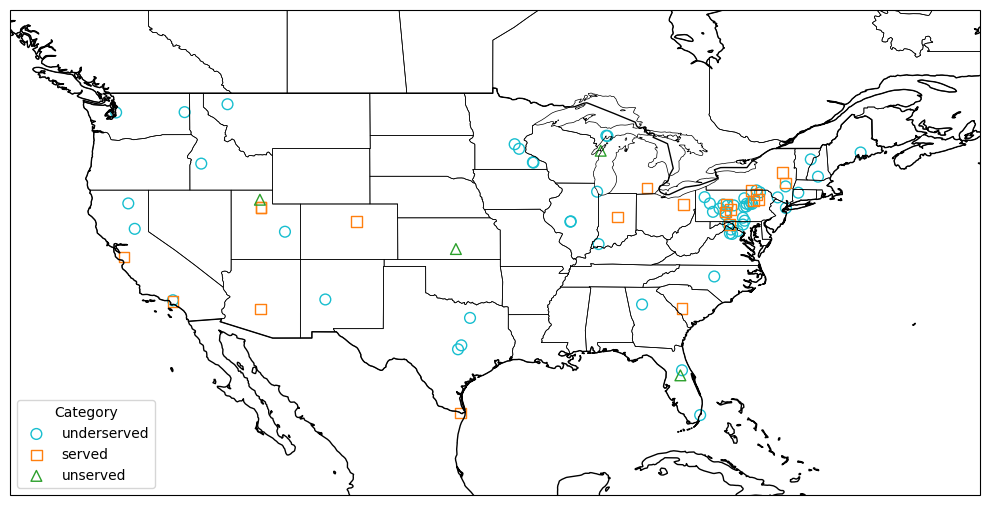

In [17]:
# Mapping each sample

# Define a list of unique marker styles
marker_styles = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']
colors = ['#17becf', "#ff7f0e", '#2ca02c']
us_starlink_samples_over_10 = starlink_avg_per_loc[starlink_avg_per_loc["client_country"] == "United States of America"]
categories = us_starlink_samples['category'].unique()

# Ensure enough markers for all categories
assert len(categories) <= len(marker_styles), "Not enough marker styles for all categories."

marker_map = dict(zip(categories, marker_styles))
color_map = dict(zip(categories, colors))
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

# Plot each category with a different marker
for category in categories:
    subset = us_starlink_samples_over_10[us_starlink_samples['category'] == category]
    ax.scatter(
        subset['client_longitude'],
        subset['client_latitude'],
        marker=marker_map[category],
        label=category,
        s=60,
        facecolors='none',   # hollow marker
        edgecolors=color_map[category],  # visible outline
        linewidth=1,
        transform=ccrs.PlateCarree()
    )

# Add legend and title
ax.legend(title='Category', loc='lower left')
plt.tight_layout()
plt.show()

In [18]:
# Filtering EU countries
eu_max = starlink_max_per_loc[starlink_max_per_loc["client_country"].isin(eu_countries)]
eu_avg = starlink_avg_per_loc[starlink_avg_per_loc["client_country"].isin(eu_countries)]

print("Percentage of EU samples with max tput >= 100 Mbps:", len(eu_max[eu_max["MeanThroughputMbps"] >= 100]) / len(eu_max))
print("Percentage of EU samples with avg tput >= 100 Mbps:", len(eu_avg[eu_avg["MeanThroughputMbps"] >= 100]) / len(eu_avg))

starlink_avg_per_loc[starlink_avg_per_loc["client_country"].isin(eu_countries)]["category"].value_counts(normalize=True)

Percentage of EU samples with max tput >= 100 Mbps: 1.0
Percentage of EU samples with avg tput >= 100 Mbps: 0.045454545454545456


category
underserved    0.954545
served         0.045455
unserved       0.000000
Name: proportion, dtype: float64

In [19]:
# Filtering for Australia
au_max = starlink_max_per_loc[starlink_max_per_loc["client_country"] == "Australia"]
au_avg = starlink_avg_per_loc[starlink_avg_per_loc["client_country"] == "Australia"]

print("Percentage of AU samples with max tput >= 100 Mbps:", len(au_max[au_max["MeanThroughputMbps"] >= 100]) / len(au_max))
print("Percentage of AU samples with avg tput >= 100 Mbps:", len(au_avg[au_avg["MeanThroughputMbps"] >= 100]) / len(au_avg))

Percentage of AU samples with max tput >= 100 Mbps: 0.96875
Percentage of AU samples with avg tput >= 100 Mbps: 0.40625


Now looking at household income analysis

In [20]:
# Attempting to extract address from the latitude/longitude of NDT sample
geolocator = geopy.Nominatim(user_agent="check_1")
def get_zip_code(x):
    try:
        location = geolocator.reverse("{}, {}".format(x['client_latitude'],x['client_longitude']))
    except:
        return None
    return location.raw['address']
us_starlink_samples_over_10["address"] = us_starlink_samples_over_10.progress_apply(get_zip_code, axis=1)
us_starlink_samples_over_10["zipcode"] = us_starlink_samples_over_10.progress_apply(lambda x: x["address"].get("postcode", "none") if x is not None else "none", axis=1)
us_starlink_samples_over_10["county"] = us_starlink_samples_over_10.progress_apply(lambda x: x["address"].get("county", "none") if x is not None else "none", axis=1)
us_starlink_samples_over_10["state"] = us_starlink_samples_over_10.progress_apply(lambda x: x["address"].get("state", "none")  if x is not None else "none", axis=1)

100%|██████████| 85/85 [02:01<00:00,  1.43s/it]
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/268307102.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["address"] = us_starlink_samples_over_10.progress_apply(get_zip_code, axis=1)
100%|██████████| 85/85 [00:00<00:00, 44709.79it/s]
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/268307102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["zipcode"] = us_starlink

In [23]:
# Loading in zipcode data from US census
zipcode_income = pd.read_csv("zipcode_income.csv")

# Creating zipcode to income dictionary
zipcode_income["zipcode"] = zipcode_income.progress_apply(lambda x: x["NAME"][-5:], axis=1)
zipcode_to_income = dict(zip(zipcode_income["zipcode"], zipcode_income["S1901_C01_012E"]))

# Adding income of zipcode sample belongs to 
us_starlink_samples_over_10["zipcode_income"] = us_starlink_samples_over_10["zipcode"].map(zipcode_to_income)
cleaned_us_starlink_samples_over_10 = us_starlink_samples_over_10[(us_starlink_samples_over_10["zipcode_income"] != "-") & (~us_starlink_samples_over_10["zipcode_income"].isna())]

# Need to replace 250k+ string and floor with 250000
cleaned_us_starlink_samples_over_10["zipcode_income"] = (
    cleaned_us_starlink_samples_over_10["zipcode_income"].replace("250,000+", "250000")
)
cleaned_us_starlink_samples_over_10["zipcode_income"] = cleaned_us_starlink_samples_over_10["zipcode_income"].astype(float)

/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/3929833515.py:2: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  zipcode_income = pd.read_csv("zipcode_income.csv")
100%|██████████| 33773/33773 [00:00<00:00, 273123.15it/s]
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/3929833515.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["zipcode_income"] = us_starlink_samples_over_10["zipcode"].map(zipcode_to_income)
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/3929833515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Processing non-Starlink data as point of comparison.. query found above

In [38]:
non_starlink_locs = pd.read_csv("non_starlink_data.csv")
non_starlink_locs = non_starlink_locs.rename(columns={"f0_": "MeanThroughputMbps", "f1_": "LossRate"})
non_starlink_avg_per_country = non_starlink_locs.groupby(["client_country_code"])["MeanThroughputMbps"].mean().reset_index()
non_starlink_us_sample = non_starlink_locs[non_starlink_locs["client_country_code"] == "US"].sample(200)
non_starlink_us_sample["address"] = non_starlink_us_sample.progress_apply(get_zip_code, axis=1)
non_starlink_us_sample= non_starlink_us_sample[~non_starlink_us_sample["address"].isna()]
non_starlink_us_sample["zipcode"] = non_starlink_us_sample.progress_apply(lambda x: x.get("address", "none").get("postcode", "none") if x is not None else "none", axis=1)
non_starlink_us_sample["zipcode_income"] = non_starlink_us_sample["zipcode"].map(zipcode_to_income)
cleaned_non_starlink_us_sample = non_starlink_us_sample[(non_starlink_us_sample["zipcode_income"] != "-") & (~non_starlink_us_sample["zipcode_income"].isna())]
cleaned_non_starlink_us_sample["zipcode_income"] = (
    cleaned_non_starlink_us_sample["zipcode_income"].replace("250,000+", "250000")
)
cleaned_non_starlink_us_sample["zipcode_income"] = cleaned_non_starlink_us_sample["zipcode_income"].astype(float)

100%|██████████| 200/200 [00:00<00:00, 103627.03it/s]
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/576063834.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_non_starlink_us_sample["zipcode_income"] = (
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/576063834.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_non_starlink_us_sample["zipcode_income"] = cleaned_non_starlink_us_sample["zipcode_income"].astype(float)


In [43]:
# Helper function for plotting income vs. throughput
def plot_income_vs_throughput(
    x,
    y,
    xlabel,
    xlim,
    outfile,
    title=None,
):
    """
    Fits linear regression, removes IQR outliers (for slope estimation),
    but plots regression line from full data (matching original behavior).
    """

    df = pd.DataFrame({"x": x, "y": y})

    # Force numeric, drop junk
    df["x"] = pd.to_numeric(df["x"], errors="coerce") / 1000
    df["y"] = pd.to_numeric(df["y"], errors="coerce")

    df = df.dropna()

    # --- Full model ---
    model = LinearRegression()
    model.fit(df[['x']], df['y'])

    # Residuals
    df['residuals'] = df['y'] - model.predict(df[['x']])

    # --- IQR outlier detection ---
    Q1 = df['residuals'].quantile(0.25)
    Q3 = df['residuals'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_no_outliers = df[
        (df['residuals'] >= lower) & (df['residuals'] <= upper)
    ]

    # --- Model without outliers (used for slope reporting) ---
    model_no_outliers = LinearRegression()
    model_no_outliers.fit(df_no_outliers[['x']], df_no_outliers['y'])

    slope = model_no_outliers.coef_[0]
    r2 = model_no_outliers.score(df[['x']], df['y'])

    print(f"Slope: {slope:.2f}, R²: {r2:.2f}")

    # --- Plot ---
    plt.figure()
    plt.scatter(df['x'], df['y'], zorder=10)

    plt.plot(
        df['x'],
        model.predict(df[['x']]),
        color='red',
        label=f"Slope: {slope:.2f}, $R^2$: {r2:.2f}",
    )

    plt.rc('legend', fontsize=12)
    plt.rcParams.update({'mathtext.default': 'regular'})

    plt.xlabel(xlabel)
    plt.ylabel("Throughput (Mbps)")
    plt.xlim(*xlim)
    plt.legend(loc="upper right")

    if title:
        plt.title(title)

    plt.savefig(outfile, dpi=1000)
    plt.show()

Slope: 0.56, R²: 0.05


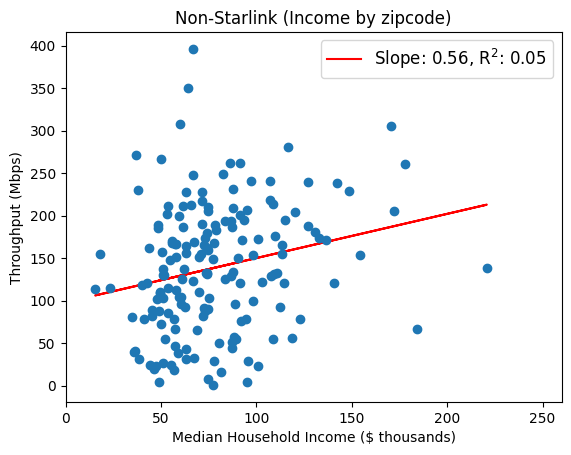

In [71]:
plot_income_vs_throughput(
    x=cleaned_non_starlink_us_sample["zipcode_income"],
    y=cleaned_non_starlink_us_sample["MeanThroughputMbps"],
    xlabel="Median Household Income ($ thousands)",
    xlim=(0, 260),
    outfile="results/scatter_zipcode_income_non_starlink.pdf",
    title="Non-Starlink (Income by zipcode)"
)


Slope: -0.14, R²: -0.03


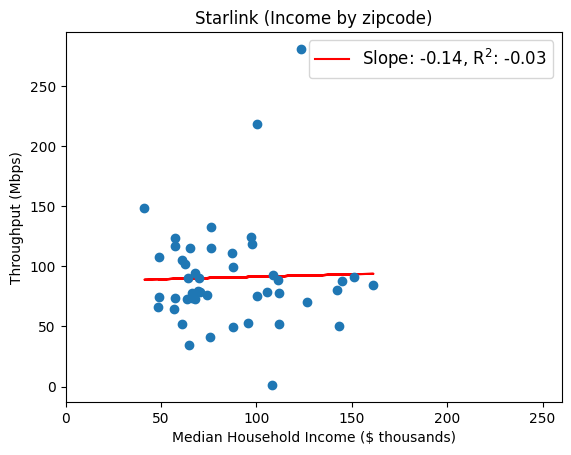

In [72]:
plot_income_vs_throughput(
    x=cleaned_us_starlink_samples_over_10["zipcode_income"],
    y=cleaned_us_starlink_samples_over_10["MeanThroughputMbps"],
    xlabel="Median Household Income ($ thousands)",
    xlim=(0, 260),
    outfile="results/scatter_zipcode_income_starlink.pdf",
    title="Starlink (Income by zipcode)"
)


### County level analysis

In [49]:
# Processing income by county according to US census data 
income_county_csv = pd.read_csv("income_by_county.csv")
columns = income_county_csv.columns 

def clean_columns(name):
    name_idx = name.find("!!Households")
    if name[name_idx + len("!!Households"):] == "!!Estimate":
        return name[:name_idx]
    else:
        return name[:name_idx] + name[name_idx + len("!!Households"):]

cleaned_columns = [clean_columns(name) for name in columns]
income_county_csv.columns = cleaned_columns
# Get the 11th row (index 10) as a Series
median_income_row = income_county_csv.iloc[11]

# Convert to dictionary: keys = county names (column names), values = median incomes
county_income_dict = median_income_row.to_dict()
us_starlink_samples_over_10["county_income"] = us_starlink_samples_over_10.progress_apply(lambda x: county_income_dict.get(f"{x['county']}, {x['state']}", "None"), axis=1)
def clean_to_int(val):
    try:
        return int(str(val).replace(",", "").strip())
    except (ValueError, TypeError):
        return None  # or np.nan

us_starlink_samples_over_10["county_income"] = us_starlink_samples_over_10["county_income"].apply(clean_to_int)
non_starlink_us_sample["county"] = non_starlink_us_sample.progress_apply(lambda x: x["address"].get("county", "none") if x is not None else "none", axis=1)
non_starlink_us_sample["state"] = non_starlink_us_sample.progress_apply(lambda x: x["address"].get("state", "none")  if x is not None else "none", axis=1)
non_starlink_us_sample["county_income"] = non_starlink_us_sample.progress_apply(lambda x: county_income_dict.get(f"{x['county']}, {x['state']}", "None"), axis=1)
non_starlink_us_sample["county_income"] = non_starlink_us_sample["county_income"].apply(clean_to_int)

100%|██████████| 85/85 [00:00<00:00, 68219.64it/s]
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/1174531361.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["county_income"] = us_starlink_samples_over_10.progress_apply(lambda x: county_income_dict.get(f"{x['county']}, {x['state']}", "None"), axis=1)
/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/1174531361.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["co

In [34]:
# Quintiles derived from https://taxpolicycenter.org/statistics/household-income-quintiles
bins = [0, 30000, 58020, 94000,153000, float("inf")]

bin_labels = ["first", "second", "third", "fourth", "fifth"]
non_starlink_us_sample["income_quintile"] = pd.cut(non_starlink_us_sample["county_income"], right=False, bins=bins, labels=bin_labels)
us_starlink_samples_over_10["income_quintile"] = pd.cut(us_starlink_samples_over_10["county_income"], right=False, bins=bins, labels=bin_labels)
category_mapping = {"served": "[100,∞)", "underserved": "[25,100)", "unserved": "[0,25)"}
bins = [0, 25, 100, float("inf")]
bin_labels = ["unserved", "underserved", "served"]
non_starlink_us_sample["category"] = pd.cut(non_starlink_us_sample["MeanThroughputMbps"], right=False, bins=bins, labels=bin_labels)
non_starlink_us_sample["category_range"] = non_starlink_us_sample["category"].map(category_mapping)
cleaned_non_starlink_us_sample = non_starlink_us_sample[~non_starlink_us_sample["income_quintile"].isna()]
cleaned_us_starlink_samples_over_10 = us_starlink_samples_over_10[~us_starlink_samples_over_10["income_quintile"].isna()]

/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/1324034738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_starlink_samples_over_10["income_quintile"] = pd.cut(us_starlink_samples_over_10["county_income"], right=False, bins=bins, labels=bin_labels)


In [36]:
cleaned_us_starlink_samples_over_10["income_quintile"].value_counts()

income_quintile
third     37
fourth    14
second     5
fifth      2
first      0
Name: count, dtype: int64

Showing difference between top10% and bottom 10% of Starlink vs. non-Starlink throughput

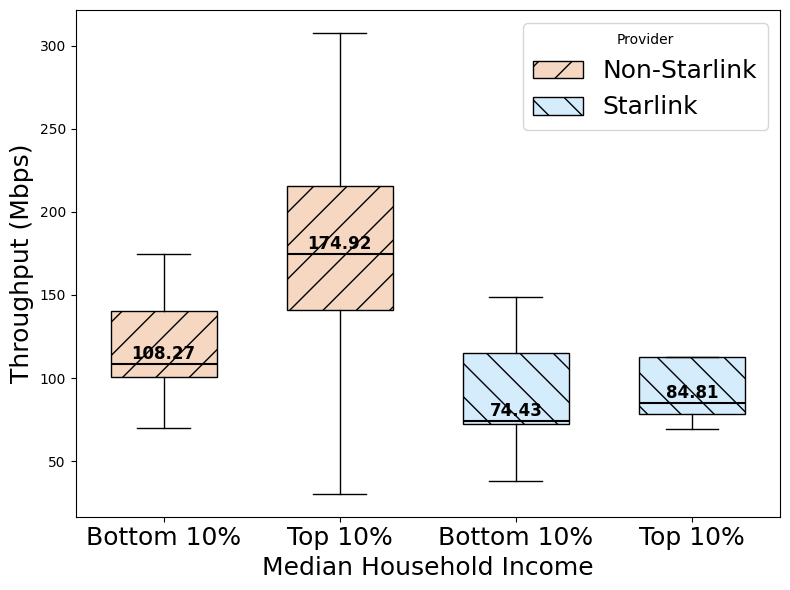

'\n# --- Plot 1: Non-Starlink only (Starlink spacing preserved) ---\nplot_boxes(combined, ["Non-Starlink"], "Non-Starlink Only")\n\n# --- Plot 2: Both Non-Starlink + Starlink ---\nplot_boxes(combined, ["Non-Starlink", "Starlink"], "Non-Starlink vs Starlink")\nplot_boxes_matplotlib(combined, ["Non-Starlink", "Starlink"], "Throughput by Income Quintile with Hatches")\n'

In [35]:
# --- Combine datasets with a label ---
non_starlink = cleaned_non_starlink_us_sample.copy()
non_starlink["Provider"] = "Non-Starlink"

starlink = cleaned_us_starlink_samples_over_10.copy()
starlink["Provider"] = "Starlink"

combined = pd.concat([non_starlink, starlink])

# --- Drop "first" quantile if present ---
combined = combined[combined["income_quintile"] != "first"]

def plot_boxes(data, providers_to_show, title):
    plt.figure(figsize=(10,6))

    # Ensure both hues exist so spacing is consistent
    temp = data.copy()
    temp = temp[temp["Provider"].isin(providers_to_show)]

    sns.boxplot(
        data=temp,
        x="income_quintile",
        y="MeanThroughputMbps",
        hue="Provider",
        palette={"Non-Starlink": "cyan", "Starlink": "orange"},
        width=0.4,
        showcaps=True,
        boxprops={"alpha": 0.7},
        showfliers=False
    )

    # --- Median lines & labels ---
    medians = (
        data.groupby(["Provider", "income_quintile"])["MeanThroughputMbps"]
        .median()
        .reset_index()
    )
    for provider, style, color, marker in [
        ("Non-Starlink", "-", "blue", "^"),
        ("Starlink", "-", "orange", "o")
    ]:
        if provider in providers_to_show:
            subset = medians[medians["Provider"] == provider]
            plt.plot(
                subset["income_quintile"],
                subset["MeanThroughputMbps"],
                linestyle=style,
                color=color,
                marker=marker,
                label=f"{provider} Median"
            )
            # --- Add labels ---
            for x, y in zip(subset["income_quintile"], subset["MeanThroughputMbps"]):
                plt.text(
                    x, y + 0.5,  # slightly above marker
                    f"{y:.2f}",
                    ha='center',
                    va='bottom',
                    color=color,
                    fontweight='bold',
                    fontsize=9
                )

    plt.title(title)
    plt.xlabel("Income quantile")
    plt.ylabel("Avg Tput (Mbps)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()
def plot_boxes_matplotlib(data, providers_to_show, title):
    plt.figure(figsize=(10,6))

    income_quintiles = sorted(data["income_quintile"].unique())
    n_quintiles = len(income_quintiles)
    n_providers = len(providers_to_show)
    width = 0.35  # width of each box

    positions = []
    for i in range(n_quintiles):
        # compute positions for each provider within the quintile
        pos = np.arange(n_quintiles) * (n_providers + 0.5)
        positions.append(pos)

    hatch_patterns = {"Non-Starlink": "//", "Starlink": "xx"}
    colors = {"Non-Starlink": "cyan", "Starlink": "orange"}

    # Loop over providers and plot boxes
    all_boxes = []
    for j, provider in enumerate(providers_to_show):
        box_data = []
        pos = []
        for i, quintile in enumerate(income_quintiles):
            values = data[(data["income_quintile"] == quintile) & (data["Provider"] == provider)]["MeanThroughputMbps"]
            if len(values) > 0:
                box_data.append(values)
                pos.append(i + j*width)
        if box_data:
            bp = plt.boxplot(
                box_data,
                positions=pos,
                widths=width,
                patch_artist=True,
                showfliers=False
            )
            for patch in bp['boxes']:
                patch.set_facecolor(colors[provider])
                patch.set_hatch(hatch_patterns[provider])
            # --- Add median labels ---
            medians = [np.median(d) for d in box_data]
            for x, median in zip(pos, medians):
                plt.text(x, median + 0.5, f"{median:.2f}",
                         ha='center', va='bottom', color='black', fontweight='bold')
            all_boxes.append(bp)

    # --- X-axis ---
    mid_positions = [i + width/2 for i in range(n_quintiles)]
    plt.xticks(mid_positions, income_quintiles, rotation=25)

    plt.ylabel("Avg Throughput (Mbps)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_top_bottom(data, providers_to_show, title):
    plt.figure(figsize=(8,6))

    groups = []
    labels = []
    provider_labels = []

    for provider in providers_to_show:
        subset = data[data["Provider"] == provider].sort_values("county_income")

        n = len(subset)
        bottom_n = max(1, int(0.1 * n))  # at least 1 sample
        top_n = max(1, int(0.1 * n))

        bottom_group = subset.head(bottom_n)["MeanThroughputMbps"].values
        top_group = subset.tail(top_n)["MeanThroughputMbps"].values

        groups.append(bottom_group)
        labels.append("Bottom 10%")
        provider_labels.append(provider)

        groups.append(top_group)
        labels.append("Top 10%")
        provider_labels.append(provider)

    # Plot boxplots
    positions = np.arange(len(groups))
    width = 0.6
    colors = {"Non-Starlink": "#f6d7c1", "Starlink": "#d5ecfd"}
    hatches = {"Non-Starlink": "/", "Starlink": "\\"}

    bp = plt.boxplot(groups, positions=positions, widths=width,
                     patch_artist=True, showfliers=False)

    # Style each box and set median line color to black
    for i, patch in enumerate(bp['boxes']):
        provider = provider_labels[i]
        patch.set_facecolor(colors[provider])
        patch.set_hatch(hatches[provider])

    # Set median lines to black
    for median_line in bp['medians']:
        median_line.set(color='black', linewidth=1.5)

    # Add median labels
    for i, median_line in enumerate(bp['medians']):
        median_val = median_line.get_ydata()[0]
        plt.text(positions[i], median_val + 0.5, f"{median_val:.2f}",
                 ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

    # X-axis ticks
    xtick_labels = labels
    plt.xticks(positions, xtick_labels, fontsize=18)

    plt.ylabel("Throughput (Mbps)", fontsize=18)
    plt.title(title)

    # Manual legend
    legend_handles = [Patch(facecolor=colors[p], hatch=hatches[p], label=p, edgecolor="black") for p in providers_to_show]
    plt.legend(handles=legend_handles, title="Provider", fontsize=18)

    
    plt.xlabel("Median Household Income", fontsize=18)
    plt.tight_layout()
    plt.savefig("results/us_10_pct.pdf", dpi=1000)
    plt.show()
    


# --- Example usage ---
plot_top_bottom(combined, ["Non-Starlink", "Starlink"], "")
'''
# --- Plot 1: Non-Starlink only (Starlink spacing preserved) ---
plot_boxes(combined, ["Non-Starlink"], "Non-Starlink Only")

# --- Plot 2: Both Non-Starlink + Starlink ---
plot_boxes(combined, ["Non-Starlink", "Starlink"], "Non-Starlink vs Starlink")
plot_boxes_matplotlib(combined, ["Non-Starlink", "Starlink"], "Throughput by Income Quintile with Hatches")
'''



Slope: 0.96, R²: 0.03


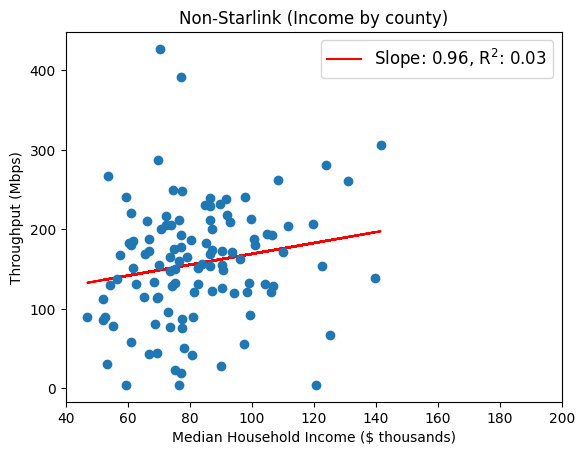

In [73]:
mask = ~non_starlink_us_sample["county_income"].isna()

plot_income_vs_throughput(
    x=non_starlink_us_sample.loc[mask, "county_income"],
    y=non_starlink_us_sample.loc[mask, "MeanThroughputMbps"],
    xlabel="Median Household Income ($ thousands)",
    xlim=(40, 200),
    outfile="results/scatter_county_income_non_starlink.pdf",
    title="Non-Starlink (Income by county)"
)


Slope: 0.18, R²: 0.00


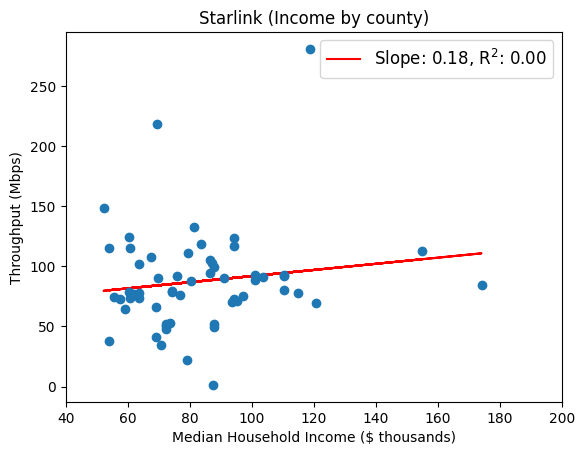

In [74]:
mask = ~us_starlink_samples_over_10["county_income"].isna()

plot_income_vs_throughput(
    x=us_starlink_samples_over_10.loc[mask, "county_income"],
    y=us_starlink_samples_over_10.loc[mask, "MeanThroughputMbps"],
    xlabel="Median Household Income ($ thousands)",
    xlim=(40, 200),
    outfile="results/scatter_county_income_starlink.pdf",
    title="Starlink (Income by county)"
)


### Country level analysis 

In [56]:
country_classification_df = pd.read_csv("country_classification_df_2025.csv", index_col=0)
starlink_avg_per_loc = starlink_avg_per_loc.set_index("client_country_code").join(country_classification_df).reset_index()

Visualizing breakdown of throughput according to country classification 

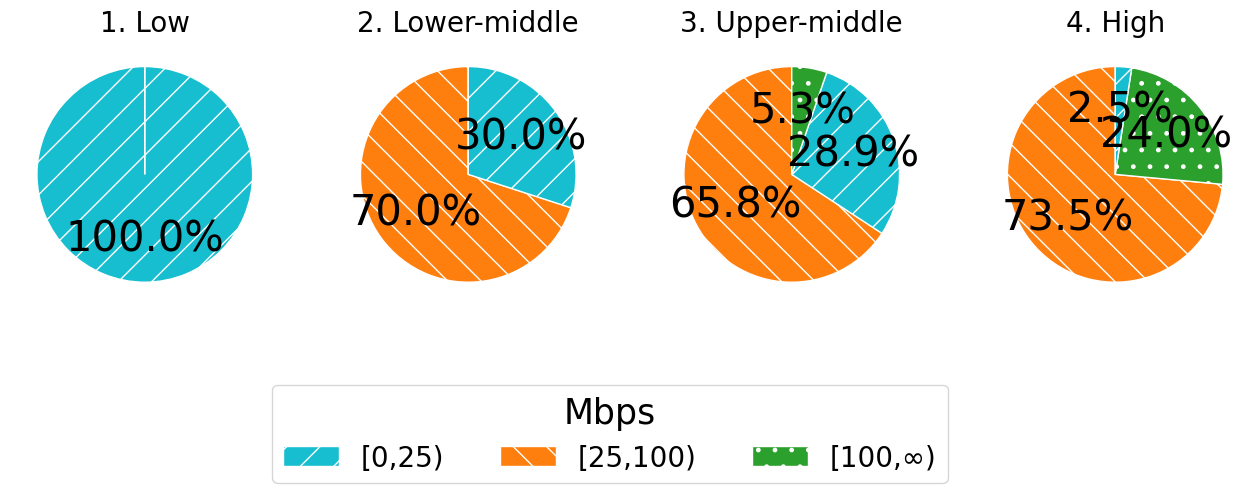

In [58]:
service_categories = ['[0,25)', '[25,100)', '[100,∞)']
statuses = ["1. Low","2. Lower-middle","3. Upper-middle","4. High"]
category_mapping = {"served": "[100,∞)", "underserved": "[25,100)", "unserved": "[0,25)"}
starlink_avg_per_loc["category_range"] = starlink_avg_per_loc["category"].map(category_mapping)
fig, axes = plt.subplots(1, 4, figsize=(16, 5))  # Changed from (2, 2) to (1, 4)
axes = axes.flatten()

# Get all income groups to ensure consistent colors
default_colors = ['#17becf', "#ff7f0e", '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = default_colors[:len(service_categories)]
# Map income groups to colors
color_map = {group: colors[i] for i, group in enumerate(service_categories)}

allowed_labels = ["Available", "Planned for future", "Unknown"]


# Define a list of hatching patterns (repeat if fewer than income groups)
hatch_patterns = ['/', '\\', '.', '-', '+', 'x', '|', 'O', '.', '*']
hatch_map = {group: hatch_patterns[i % len(hatch_patterns)] for i, group in enumerate(service_categories)}

for i, status in enumerate(statuses):
    subset = starlink_avg_per_loc[starlink_avg_per_loc['status'] == status]
    income_counts = subset['category_range'].value_counts()
    group_colors = [color_map[group] for group in income_counts.index]
    group_hatches = [hatch_map[group] for group in income_counts.index]

    # Custom autopct that tracks index for label mapping
    def make_autopct(values, labels):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            idx = my_autopct.idx
            label = labels[idx]
            my_autopct.idx += 1
            return f'{pct:.1f}%' if  val > 0 else ''
        my_autopct.idx = 0
        return my_autopct

    wedges, _, _ = axes[i].pie(
        income_counts.values,
        labels=None,
        colors=group_colors,
        startangle=90,
        autopct=make_autopct(income_counts.values, income_counts.index),
        textprops={'fontsize': 30}
    )

    # Apply hatching to each wedge
    for wedge, hatch in zip(wedges, group_hatches):
        wedge.set_hatch(hatch)
        wedge.set_edgecolor("white")

    axes[i].set_title(f'{status}', fontsize=20)

# Use Patch instead of Line2D to show aboth color and hatch in legend
handles = [
    Patch(
        facecolor=color_map[group],
        hatch=hatch_map[group],
        label=group,
        edgecolor='white'
    )
    for group in service_categories
]


fig.legend(handles=handles, loc='lower center', ncols=3, title="Mbps", fontsize=20, title_fontsize=25,bbox_to_anchor=(0.5, -0.15))#,
            #handleheight=2.0,    # <<-- height of patch handles
   # handlelength=2.5 )
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
#fig.suptitle("Economic Classification", fontsize=22, y=.9, ha="center")
#plt.tight_layout(rect=[0, 0, 0, 1])  # Leave space for legend

plt.savefig("results/service_pie.pdf")
plt.show()

Visualizing eastern vs. western european samples

Coefficients: 
 [0.00123841]
R^2: 0.17


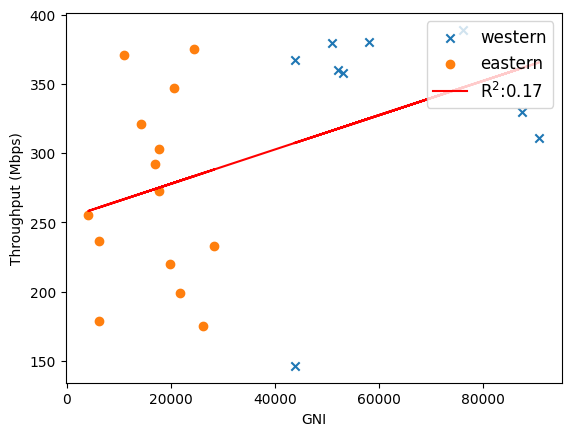

In [59]:
western_eu_starlink_samples_over_10 = starlink_avg_per_loc[starlink_avg_per_loc["client_country_code"].isin(western_europe)]
eastern_eu_starlink_samples_over_10 = starlink_avg_per_loc[starlink_avg_per_loc["client_country_code"].isin(eastern_europe)]
western_eu_starlink_samples_over_10_max = starlink_max_per_loc[starlink_max_per_loc["client_country_code"].isin(western_europe)]
eastern_eu_starlink_samples_over_10_max = starlink_max_per_loc[starlink_max_per_loc["client_country_code"].isin(eastern_europe)]

eu_samples = pd.concat([western_eu_starlink_samples_over_10_max, eastern_eu_starlink_samples_over_10_max])
df_clean = starlink_max_per_loc.dropna()
df = pd.DataFrame()
df["x"] = eu_samples["gni"]
df["y"] =  eu_samples["MeanThroughputMbps"]
# Fit linear regression model
model = LinearRegression()
model.fit(df[['x']], df['y'])

# Calculate residuals
df['residuals'] = df['y'] - model.predict(df[['x']])

# Identify outliers using IQR method
Q1 = df['residuals'].quantile(0.25)
Q3 = df['residuals'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['residuals'] < lower_bound) | (df['residuals'] > upper_bound)]

# Remove outliers
df_no_outliers = df[~df.index.isin(outliers.index)]

# Fit new model without outliers
model_no_outliers = LinearRegression()
model_no_outliers.fit(df_no_outliers[['x']], df_no_outliers['y'])
# The coefficients
print("Coefficients: \n", model_no_outliers.coef_)
# The R^2
print("R^2: %.2f" % model_no_outliers.score(df[['x']], df['y']))
plt.rc('font',**{'size':10, 'family':'sans-serif'}) #,'sans-serif':['Computer Modern Sans serif']})
plt.rc('legend', fontsize=12)

# Plot data with regression lines
ax = plt.scatter(western_eu_starlink_samples_over_10_max["gni"], western_eu_starlink_samples_over_10_max["MeanThroughputMbps"], marker="x", label="western")
plt.scatter(eastern_eu_starlink_samples_over_10_max["gni"], eastern_eu_starlink_samples_over_10_max["MeanThroughputMbps"], marker="o", label="eastern")
plt.plot(df['x'], model.predict(df[['x']]), color='red', label=r"$R^2$:" + f"{ model_no_outliers.score(df[['x']], df['y']):.2f}")
#plt.plot(df_no_outliers['x'], model_no_outliers.predict(df_no_outliers[['x']]), color='green', label=r"No outliers $R^2$:" + f"{ model_no_outliers.score(df_no_outliers[['x']], df_no_outliers['y']):.2f}")
#plt.scatter(outliers['x'], outliers['y'], color='orange', label='Outliers',zorder=11)

plt.rcParams.update({'mathtext.default':  'regular' })

plt.legend(loc="upper right", ncols=1, bbox_to_anchor=(1, 1))
plt.ylabel("Throughput (Mbps)")
plt.xlabel("GNI")
plt.savefig("results/scatter_eu.pdf")
plt.show()
#plt.savefig("scatter_eu.pdf")

### The following cell calculates how many countries that were supposed to launch in 2024 were successfully launched by then
Availability data taken directly from the Starlink website

In [65]:
# Loading in availability data
file_path = "availability2.json"
with open(file_path, 'r') as file:
    country_status = json.load(file)

country_availability_2025 = {}
for country, country_data in country_status["admin0"].items():
    status = country_data.get("status")
    if status == "coming_soon":
        country_availability_2025[country] = country_data.get("expected")
    else:
        country_availability_2025[country] = status

file_path = "availability.json"
with open(file_path, 'r') as file:
    country_status = json.load(file)

country_availability_2024 = {}
for country, country_data in country_status["admin0"].items():
    status = country_data.get("status")
    if status == "coming_soon":
        country_availability_2024[country] = country_data.get("expected")
    else:
        country_availability_2024[country] = status
country_availability_df = pd.DataFrame.from_dict(country_availability_2025, orient='index', columns=['2025'])
country_availability_df["2024"] = country_availability_df.index.map(country_availability_2024)
launched_on_time = 0
not_launched_on_time = 0
for idx, row in country_availability_df.iterrows():
    if row["2024"].find("Starting") != -1 and (row["2025"].find("launched") != -1 or row["2025"].find("available") != -1):
        launched_on_time += 1
    if row["2024"].find("Starting") != -1 and (row["2025"].find("launched") == -1 and row["2025"].find("available") == -1):
        not_launched_on_time += 1
print("Number launched on time:", launched_on_time)
print("Number not launchced on time:",not_launched_on_time)

Number launched on time: 17
Number not launchced on time: 41


### Map to show which countries are available in Africa

/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/3893178872.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


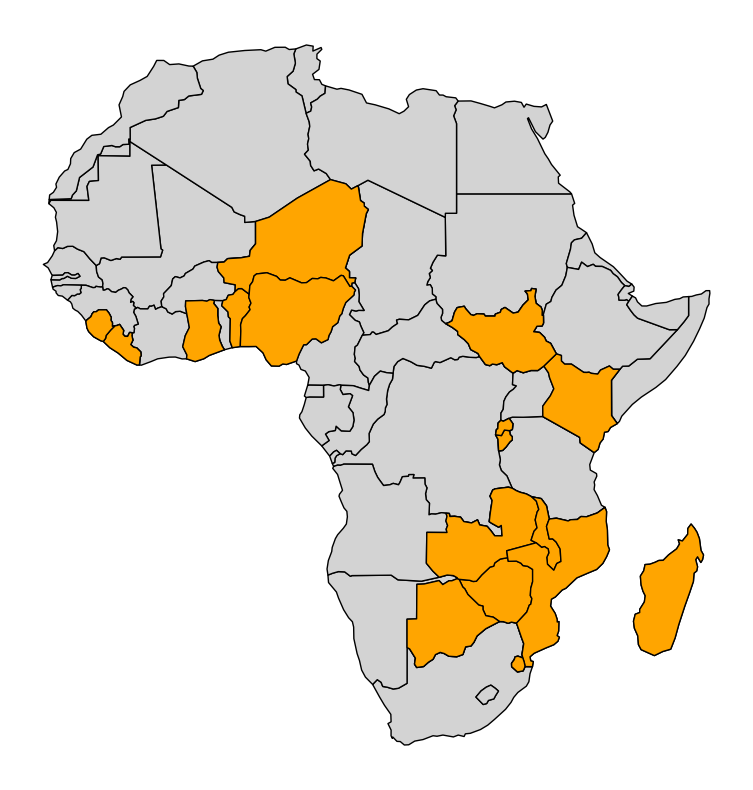

In [66]:

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Keep Africa only
africa = world[world["continent"] == "Africa"].copy()

# --- Step 1: build mapping from 2-letter to 3-letter codes ---
alpha2_to_alpha3 = {c.alpha_2: c.alpha_3 for c in pycountry.countries}

# --- Step 2: add a column with 3-letter codes from your df’s index ---
country_availability_df = country_availability_df.copy()
country_availability_df["iso_a3"] = country_availability_df.index.map(alpha2_to_alpha3)

# --- Step 3: join on iso_a3 ---
africa = africa.merge(country_availability_df, on="iso_a3", how="left")

# --- Step 4: flag highlights ---
africa["highlight"] = africa["2025"].isin(["available", "launched"])

# --- Step 5: plot ---
fig, ax = plt.subplots(figsize=(10, 10))
africa.plot(ax=ax, color="lightgrey", edgecolor="black")
africa[africa["highlight"]].plot(ax=ax, color="orange", edgecolor="black")

#ax.set_title("African Countries with status 'available' or 'launched' (2025)")
ax.axis("off")
plt.show()


Visualizing BRI vs. Starlink countries 

/var/folders/5s/9f6yz9bd1r9_3rrzfzt2lx0h0000gq/T/ipykernel_92067/1811797669.py:53: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


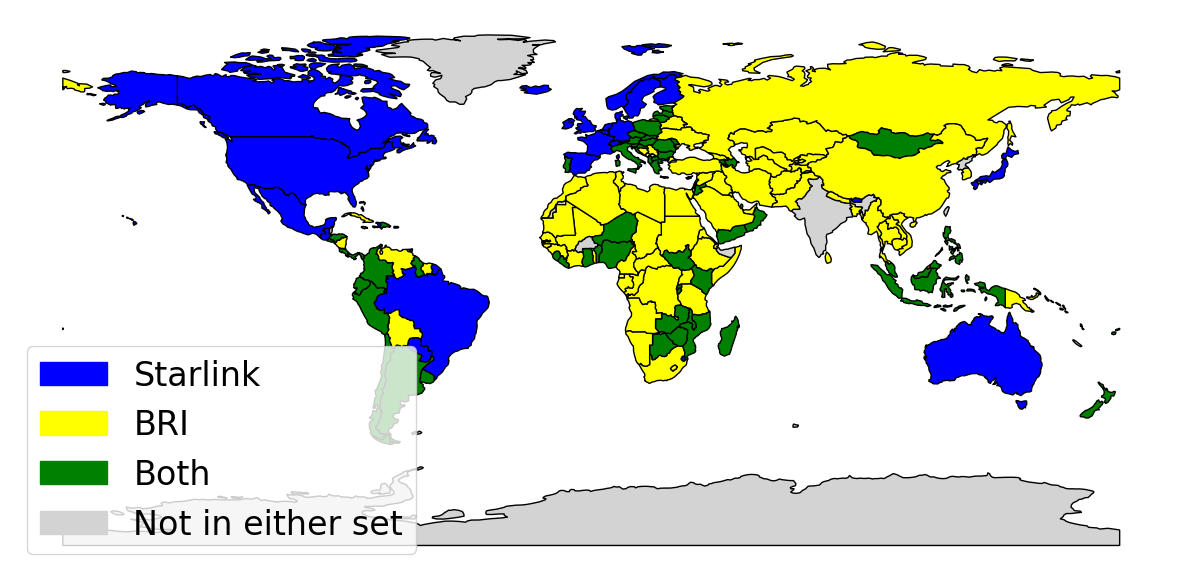

In [68]:
roads_country_codes = [
    "AF", "AL", "DZ", "AO", "AG", "AR", "AM", "AT", "AZ", "BH", "BD", "BB", "BY", "BJ", "BO", "BA", "BW", "BN", "BG", "BF", "BI", "KH", "CV", "CM", "CF", "TD", "CL", "CN", "CO", "KM", "CD", "CG", "CK", "CR", "HR", "CU", "CY", "CZ", "DJ", "DM", "DO", "EC", "EG", "SV", "GQ", "ER", "ET", "FJ", "GA", "GM", "GE", "GH", "GR", "GD", "GN", "GW", "GY", "HN", "HU", "ID", "IR", "IQ", "CI", "JM", "JO", "KZ", "KE", "KI", "KW", "KG", "LA", "LV", "LB", "LS", "LR", "LY", "LT", "LU", "MG", "MW", "MY", "MV", "ML", "MT", "MR", "MU", "FM", "MD", "MN", "ME", "MA", "MZ", "MM", "NA", "NP", "NZ", "NI", "NE", "NG", "NU", "MK", "OM", "PK", "PS", "PG", "PE", "PL", "PT", "QA", "RO", "RU", "RW", "WS", "ST", "SA", "SN", "RS", "SC", "SL", "SG", "SK", "SI", "SB", "SO", "ZA", "SS", "LK", "SD", "SR", "SY", "TJ", "TZ", "TH", "TL", "TG", "TO", "TT", "TN", "TR", "TM", "UG", "UA", "AE", "UY", "UZ", "VU", "VE", "VN", "YE", "ZM", "ZW"
]
iso3_codes = [
    "AFG","ALB","DZA","AGO","ATG","ARG","ARM","AUT","AZE","BHR","BGD","BRB","BLR","BEN",
    "BOL","BIH","BWA","BRN","BGR","BDI","CPV","KHM","CMR","CAF","TCD","CHL","CHN","COL",
    "COM","COD","COG","COK","CRI","CIV","HRV","CUB","CYP","DOM","CZE","DJI","DMA","ECU",
    "EGY","SLV","GNQ","ERI","EST","ETH","FJI","GAB","GMB","GEO","GHA","GRC","GRD","GIN",
    "GNB","GUY","HND","HUN","IDN","IRN","IRQ","ITA","JAM","JOR","KAZ","KEN","KIR","KOR",
    "KWT","KGZ","LAO","LVA","LBN","LSO","LBR","LBY","LTU","LUX","MDG","MWI","MYS","MDV",
    "MLI","MLT","MRT","FSM","MDA","MNG","MNE","MAR","MOZ","MMR","NAM","NPL","NZL","NIC",
    "NER","NGA","NIU","MKD","OMN","PAK","PAN","PNG","PER","PHL","POL","PRT","QAT","ROU",
    "RUS","RWA","WSM","SAU","SEN","SRB","SYC","SLE","SGP","SVK","SVN","SLB","SOM","ZAF",
    "SSD","LKA","SDN","SUR","SYR","TJK","TZA","THA","TLS","TGO","TON","TTO","TUN","TUR",
    "TKM","UGA","UKR","ARE","URY","UZB","VUT","VEN","VNM","YEM","ZMB","ZWE"
]

# Function to convert ISO3 -> ISO2
def iso3_to_iso2(iso3_set):
    iso2_set = set()
    for code in iso3_set:
        try:
            country = pycountry.countries.get(alpha_3=code)
            if country:
                iso2_set.add(country.alpha_2)
            else:
                print(f"Warning: {code} not found in pycountry database")
        except Exception as e:
            print(f"Error converting {code}: {e}")
    return iso2_set

# Convert
roads_country_codes = iso3_to_iso2(iso3_codes)

starlink_country_codes = list(country_availability_df[(country_availability_df["2025"] == "launched") | (country_availability_df["2025"] == "available")].index)

# Sets of ISO 2-letter country codes
set1 = set(starlink_country_codes)
set2 = set(roads_country_codes)

# Map each country to a color
country_colors = {}
all_countries = set1.union(set2)
for country in all_countries:
    if country in set1 and country in set2:
        country_colors[country] = "green"  # in both
    elif country in set1:
        country_colors[country] = "blue"   # only in first
    else:
        country_colors[country] = "yellow" # only in second

# Load world map from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Add a new column for color based on ISO 2-letter code
# GeoPandas uses ISO_A2 for 2-letter codes
def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

world["iso_a2"] = world["iso_a3"].apply(iso3_to_iso2)
world['color'] = world['iso_a2'].map(country_colors).fillna('lightgrey')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(color=world['color'], edgecolor='black', ax=ax)

# Add legend manually
legend_handles = [
    mpatches.Patch(color='blue', label='Starlink'),
    mpatches.Patch(color='yellow', label='BRI'),
    mpatches.Patch(color='green', label='Both'),
    mpatches.Patch(color='lightgrey', label='Not in either set')
]
ax.legend(handles=legend_handles, loc="lower left", fontsize=24, markerscale=2)

#ax.set_title("Country Set Comparison")
ax.axis('off')
plt.savefig("results/starlink_bri.pdf", dpi=1000)
plt.show()